# Exemple : Classification d'iris

Dans cet exemple, nous allons reconnaître des variétés d'iris (des fleurs) en utilisant l'algorithme des $k$ plus proches voisins.  
Le code suivant charge les données :

In [1]:
from sklearn.datasets import load_iris
import numpy as np
iris = load_iris()

<center><img src=https://raw.githubusercontent.com/cpge-itc/bcpst2/main/files/5_iris/iris.png width=60%></center>

## Description des données

`iris` est un dictionnaire tel que :
- `iris['data']` est une matrice `numpy` dont chaque ligne contient les données d'un iris : longueur, largeur de la sépale et de la pétale.  
- `iris['target']` est un vecteur contenant les variétés d'iris : setosa (0), versicolor (1) ou virginica (2).

L'objectif est donc, à partir des données d'un iris, de déterminer sa variété.

Remarque : pour accéder à une clé `k` dans un dictionnaire `d`, on peut écrire `d.k` plutôt que `d['k']`. On utilisera donc `iris.data` et `iris.target` dans la suite.

In [2]:
np.shape(iris.data) # il y a 150 iris, chacune contenant 4 caractéristiques

(150, 4)

In [3]:
iris.data[0] # les données de la première iris

array([5.1, 3.5, 1.4, 0.2])

In [4]:
iris.target[0] # l'étiquette de la première iris

0

La première iris du jeu de données a donc une longueur de sépale de 5.1 cm, une largeur de sépale de 3.5 cm, une longueur de pétale de 1.4 cm et une largeur de pétale de 0.2 cm. Elle est de la variété setosa.

In [5]:
iris.data[0]

array([5.1, 3.5, 1.4, 0.2])

Les données sont donc des points de $\mathbb{R}^4$. Pour les visualiser, on peut regarder leurs projections sur les deux premiers axes (longueur et largeur de la sépale), et sur les deux autres axes (longueur et largeur de la pétale) :

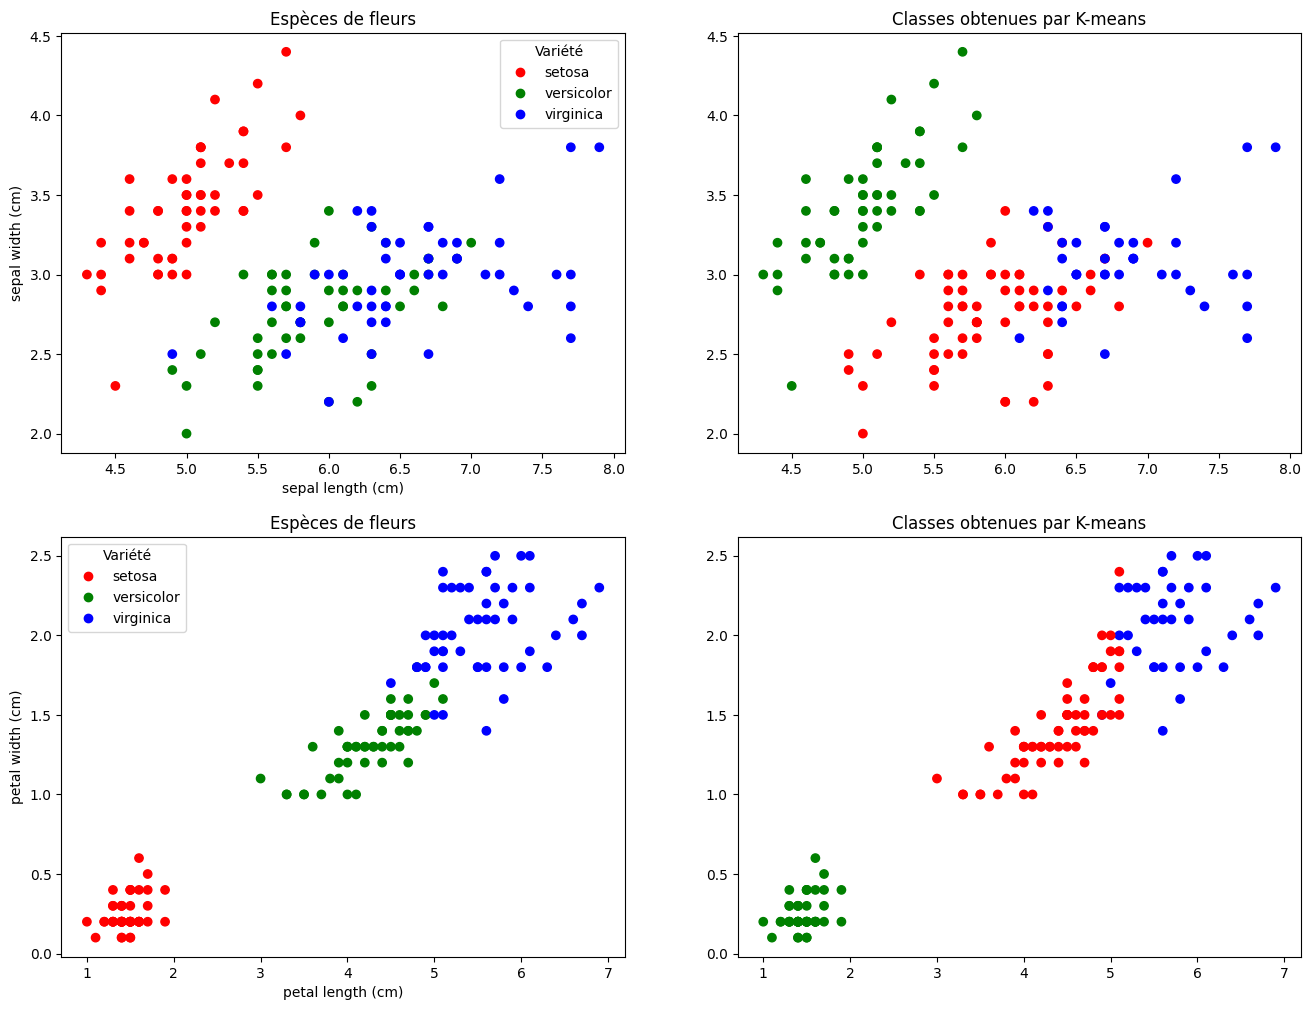

In [25]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(iris.data)
cmap = ListedColormap(["red", "green", "blue"])

fig, ax = plt.subplots(2, 2, figsize=(16,12))

for j in range(2):
    ax[j, 0].title.set_text('Espèces de fleurs')
    ax[j, 1].title.set_text('Classes obtenues par K-means')
    ax[j, 0].scatter(iris.data[:, 2*j], iris.data[:, 2*j + 1], c=iris.target, cmap=cmap)
    ax[j, 1].scatter(iris.data[:, 2*j], iris.data[:, 2*j + 1], c=kmeans.labels_, cmap=cmap)
    handles = [plt.Line2D([0, 0], [0, 0], color=cmap(norm(i)), marker='o', linestyle='', label=label) for i, label in enumerate(iris.target_names)]
    ax[j, 0].legend(handles=handles, title='Variété')
    ax[j, 0].set_xlabel(iris.feature_names[2*j])
    ax[j, 0].set_ylabel(iris.feature_names[2*j + 1])
plt.show()


## Classification

Un algorithme de classification demande de séparer les données que l'on souhaite en deux ensembles : les **données d'entraînement** (`X_train` dans la suite) que l'on utilise pour améliorer le modèle et les **données de test** (`X_test`) pour juger des performances du modèle. 

### Séparation données d'entraînement / test

Le code suivant permet de séparer l'ensemble des iris du jeu de données en deux :

In [7]:
from sklearn.model_selection import train_test_split # pour séparer les données en train et test

X_train, X_test, Y_train, Y_test = train_test_split(iris.data, iris.target, test_size=0.5, shuffle=True, random_state=0)

`X_train` contient les caractéristiques de chaque fleur des données d'entraînement. `Y_train` contient le numéro de chacune de ces fleurs (0 = setosa, 1 = versicolor, 2 = virginica). De même pour `X_test` et `Y_test`.

Remarque : on a converti les données en `numpy.array` pour pouvoir les manipuler plus facilement.

Voici par exemple les caractéristiques (longueur, largeur de sépale et de pétale) de la première fleur des données d'entraînement :

In [8]:
X_train[0]

array([4.6, 3.1, 1.5, 0.2])

Et voici sa variété de fleur :

In [9]:
Y_train[0]

0

### Algorithme des $k$ plus proches voisins

Soient $x = (x_0, x_1, x_2, x_3)$ et $y = (y_0, y_1, y_2, y_3)$ deux caractéristiques de fleurs (longueur et largeur de la sépale et de la pétale). On définit la distance euclidienne $d$ entre ces fleurs par :

$$
    d(x, y) = \sqrt{(x_0 - y_0)^2 + (x_1 - y_1)^2 + (x_2 - y_2)^2 + (x_3 - y_3)^2}
$$

In [10]:
def d2(x, y):
    return ((x[0] - y[0])**2 + (x[1] - y[1])**2 + (x[2] - y[2])**2 + (x[3] - y[3])**2)**0.5

**Remarque** : on peut aussi utiliser le fait que la distance euclidienne entre deux vecteurs $X$ et $Y$ est $\sqrt{(X - Y)^\top (X - Y)}$, ce qui est plus rapide à calculer. De plus, on ne s'intéresse qu'aux plus proches voisins, et pas à leur distance exacte. On peut donc se passer du calcul de la racine carrée, d'où la fonction ci-dessous.

In [11]:
def d2(x, y):
    z = x - y
    return z.T.dot(z)

In [12]:
def voisins(x, X, k, d): # renvoie les k plus proches voisins de x dans X
    indices = sorted(range(len(X)), key=lambda i: d(x, X[i]))
    return indices[:k]

In [13]:
def maj(L): # renvoie la classe qui apparaît le plus souvent dans L
    compte = {}
    for e in L:
        compte[e] = compte.get(e, 0) + 1
    return max(compte, key=compte.get)

In [14]:
def knn(x, X, Y, k, d): # renvoie la classe prédite pour x par l'algorithme des k plus proches voisins
    V = voisins(x, X, k, d)
    return maj([Y[i] for i in V])

In [15]:
def predict(i, k, d): # renvoie la classe prédite pour X_test[i]
    return knn(X_test[i], X_train, Y_train, k, d)

In [16]:
print("Classe prédite pour X_test[0] :", predict(0, 3, d2))
print("Classe réelle pour X_test[0] :", Y_test[0])

Classe prédite pour X_test[0] : 2
Classe réelle pour X_test[0] : 2


`plot_prediction(i, k)` affiche `X_test[i]` et les `k` plus proches voisins de `X_test[i]` dans `X_train`, ainsi que la classe prédite :

In [17]:
def plot_prediction(i, k):
    x = X_test[i]
    neighbors_i = voisins(x, X_train, k, d2)
    neighbors = X_train[neighbors_i]
    cmap = ListedColormap(["red", "green", "blue"])
    norm = plt.Normalize(iris.target.min(), iris.target.max())
    fig, ax = plt.subplots(1, 2, figsize=(16,7))
    fig.suptitle(f"Variété prédite par KNN avec k={k} : {iris.target_names[predict(i, k, d2)]}")
    for j in range(2):
        ax[j].scatter(X_train[:, 2*j], X_train[:, 2*j + 1], c=Y_train, cmap=cmap, norm=norm)
        handles = [plt.Line2D([0, 0], [0, 0], color=cmap(norm(i)), marker='o', linestyle='', label=label) for i, label in enumerate(iris.target_names)]
        ax[j].legend(handles=handles, title='Variété')
        ax[j].set_xlabel(iris.feature_names[2*j])
        ax[j].set_ylabel(iris.feature_names[2*j + 1])
        ax[j].scatter(x[2*j], x[2*j + 1], s=300, c=Y_test[i], cmap=cmap, norm=norm)
        ax[j].scatter(neighbors[:, 2*j], neighbors[:, 2*j + 1], s=120, c=Y_train[neighbors_i], cmap=cmap, norm=norm, marker='X')
    plt.show()

Sur le dessin suivant, `X_test[2]` (gros point) est correctement classée comme étant de la variété setosa :

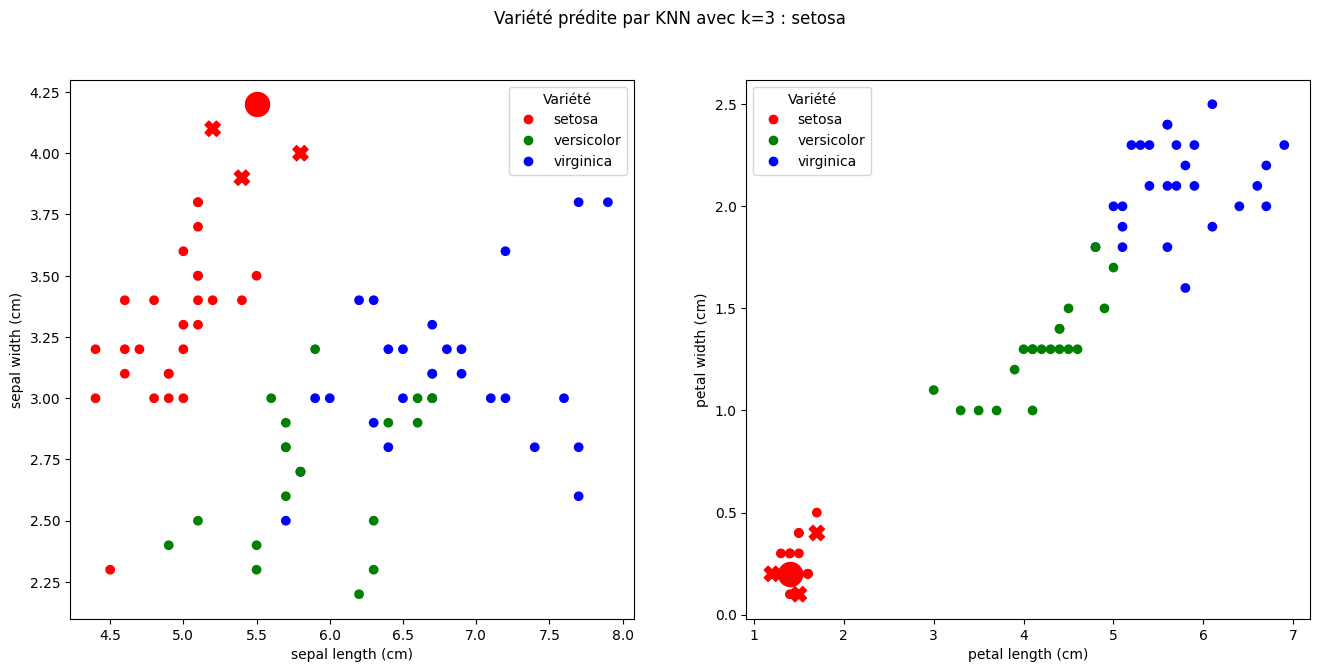

In [18]:
plot_prediction(2, 3)

Par contre, `X_test[37]` est classé à tord comme étant de la variété virginica alors qu'elle est de la variété versicolor :

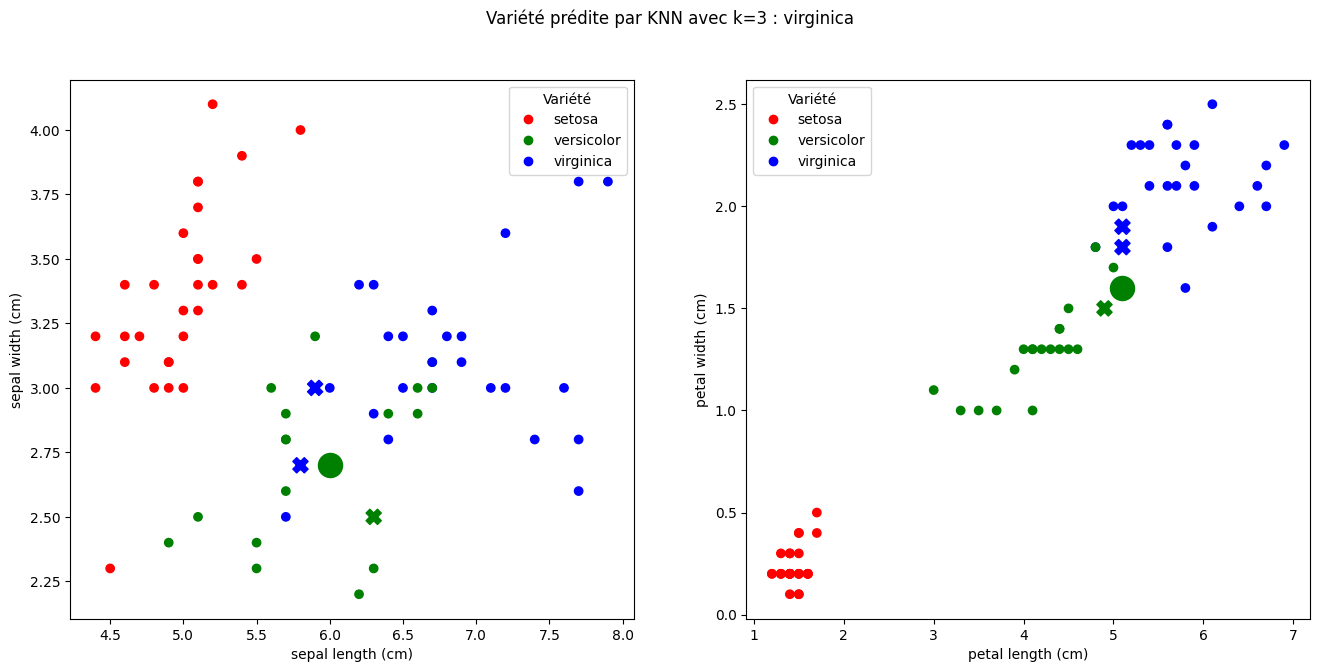

In [19]:
plot_prediction(37, 3)

## Évaluation du modèle

In [20]:
def precision(k, d):
    n = len(X_test)
    p = 0
    for i in range(n):
        if predict(i, k, d) == Y_test[i]:
            p += 1
        # else:
        # 	print(f"Erreur pour X_test[{i}] : {iris.target_names[predict(i, k)]} au lieu de {iris.target_names[Y_test[i]]}")
    return p/n

In [21]:
precision(3, d2)

0.9333333333333333

Ainsi, environ $93\%$ des iris des données de test sont correctement classés.

Pour savoir quel est le meilleur $k$, on peut afficher la précision en fonction de $k$ :

In [22]:
def plot_precision(kmax, d):
    plt.figure()
    plt.plot(range(1, kmax), [precision(k, d) for k in range(1, kmax)])
    plt.xlabel("k")
    plt.ylabel("Précision")
    plt.show()

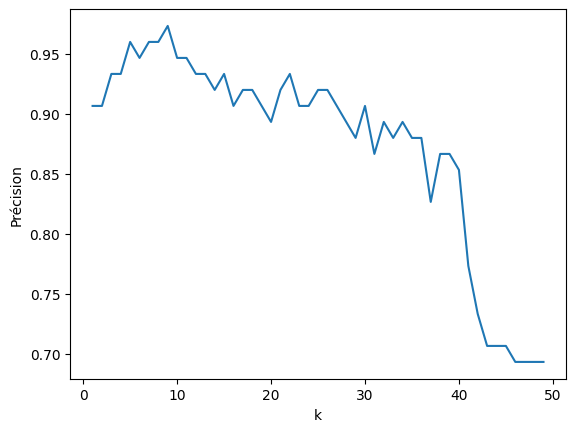

In [23]:
plot_precision(50, d2)

Zoomons sur $k \in [1, 15]$ :

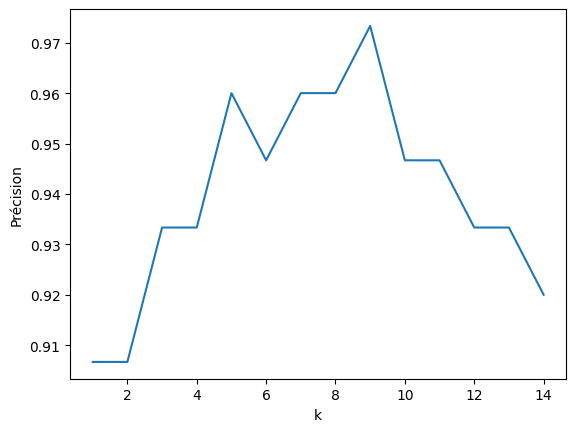

In [24]:
plot_precision(15, d2)

Graphiquement, la précision est maximale pour $k = 9$ :

In [25]:
precision(9, d2)

0.9733333333333334

On peut afficher la matrice de confusion pour $k = 9$ :

In [26]:
M = np.zeros((3, 3), dtype=int)
for i in range(len(X_test)):
    M[predict(i, 9, d2)][Y_test[i]] += 1
M

array([[21,  0,  0],
       [ 0, 29,  1],
       [ 0,  1, 23]])

Il n'y a que deux erreurs :  
- `M[1][2]` vaut 1, ce qui signifie qu'un iris de variété 2 (virginica) a été classé comme étant de variété 1 (versicolor).  
- `M[2][1]` vaut 1, ce qui signifie qu'un iris de variété 1 (versicolor) a été classé comme étant de variété 2 (virginica).

## Autres distances

Essayons d'autres distances :

### Distance de Manhattan

In [27]:
def d1(x, y):
    return sum(abs(x[i] - y[i]) for i in range(len(x)))

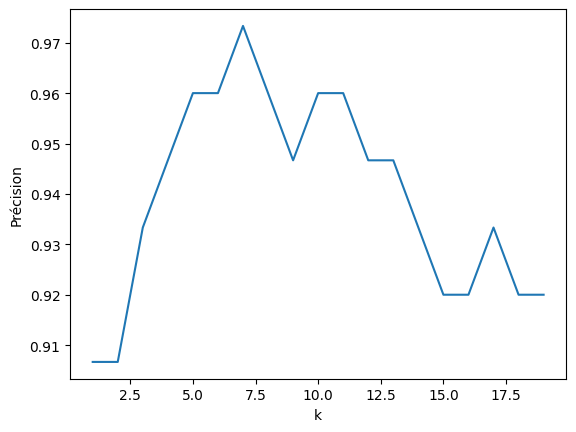

In [28]:
plot_precision(20, d1)

In [29]:
precision(9, d1) # on obtient la même précision qu'avec la distance euclidienne

0.9466666666666667

### Norme infinie

In [30]:
def d3(x, y):
    return max(abs(x[i] - y[i]) for i in range(len(x)))

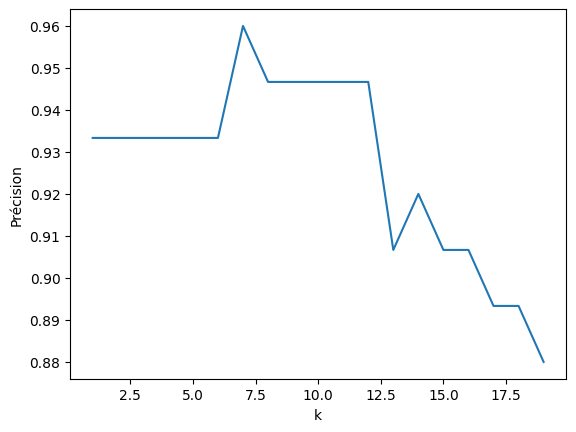

In [31]:
plot_precision(20, d3)

In [32]:
precision(7, d3)

0.96

**Conclusion** : l'utilisation d'autres distances n'a pas permis d'améliorer la précision.

## Frontière de décision

On peut afficher, pour chaque point de $\mathbb{R}^4$, la classe prédite par l'algorithme des $k$ plus proches voisins. Ici en projetant sur les deux premières coordonnées (longueur et largeur de la sépale) :

In [33]:
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay

def plot_decision_boundary(k, weights="uniform", metric="euclidean"):
    clf = neighbors.KNeighborsClassifier(k, weights=weights, metric=metric)
    clf.fit(iris.data[:, :2], iris.target)
    DecisionBoundaryDisplay.from_estimator(clf, iris.data[:, :2], cmap=cmap, response_method="predict", plot_method="pcolormesh", xlabel=iris.feature_names[0], ylabel=iris.feature_names[1], shading="auto", alpha=.5)
    sns.scatterplot(x=iris.data[:, :2][:, 0], y=iris.data[:, :2][:, 1], hue=iris.target_names[iris.target], palette=["red", "green", "blue"], edgecolor="black")

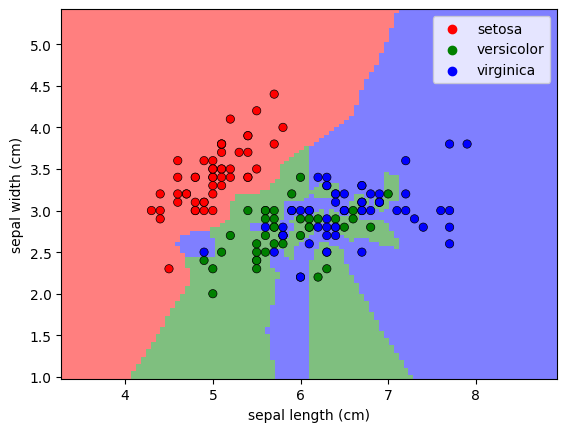

In [34]:
plot_decision_boundary(1) # k = 1

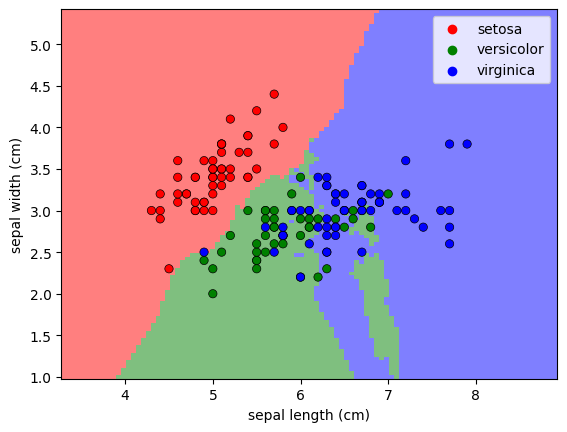

In [35]:
plot_decision_boundary(9) # k = 9

On peut voir la différence avec une autre distance, par exemple la distance de Manhattan ($d(x, y) = \sum_{i=1}^d |x_i - y_i|$) :

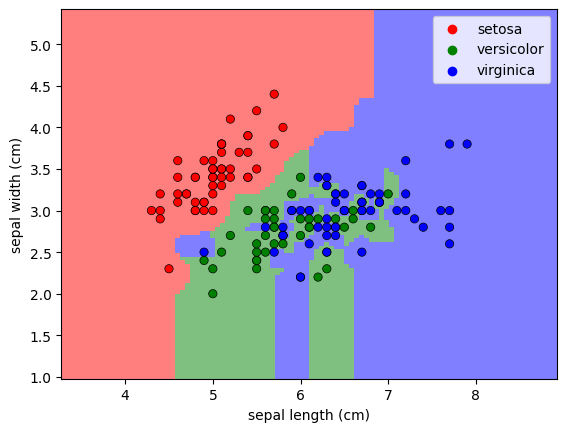

In [36]:
plot_decision_boundary(1, metric="manhattan")

## Extensions

### scikit-learn

scikit-learn est une bibliothèque Python qui contient de nombreux algorithmes d'apprentissage. Elle contient notamment [`sklearn.neighbors.KNeighborsClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) qui permet de faire de la classification par les $k$ plus proches voisins, avec beaucoup d'options. Cependant, l'objectif de ce cours est plutôt de comprendre et réécrire les algorithmes plutôt que de les utiliser comme des boîtes noires.

### Poids des voisins

Lorsqu'on considère les $k$ plus proches voisins d'une nouvelle donnée $x$, il serait intéressant d'accorder plus d'importance aux voisins les plus proches. Pour cela, on peut donner un poids à chaque voisin proportionnel à l'inverse de sa distance à $x$ (plus le voisin est proche, plus il est pertinent pour prédire la classe de $x$).  

On obtient à nouveau une précision optimale de $\approx 97\%$ :

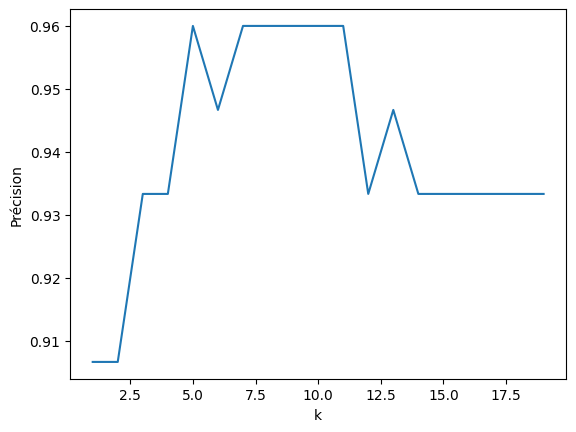

0.96

In [37]:
def maj(x, L, d): # renvoie la classe qui apparaît le plus souvent dans L
    compte = {}
    for i in L:
        if d(X_train[i], x) == 0:
            compte[Y_train[i]] = float("inf")
        else:
            compte[Y_train[i]] = compte.get(Y_train[i], 0) + 1/d(X_train[i], x)**.5
    return max(compte, key=compte.get)
    
def knn(x, X, Y, k, d): # renvoie la classe prédite pour x par l'algorithme des k plus proches voisins
    V = voisins(x, X, k, d)
    return maj(x, V, d)

def predict(i, k, d): # renvoie la classe prédite pour X_test[i]
    return knn(X_test[i], X_train, Y_train, k, d)

def plot_prediction(i, k):
    x = X_test[i]
    neighbors_i = voisins(x, X_train, k, d2)
    neighbors = X_train[neighbors_i]
    cmap = ListedColormap(["red", "green", "blue"])
    norm = plt.Normalize(iris.target.min(), iris.target.max())
    fig, ax = plt.subplots(1, 2, figsize=(16,7))
    fig.suptitle(f"Variété prédite par KNN avec k={k} : {iris.target_names[predict(i, k, d2)]}")
    for j in range(2):
        ax[j].scatter(X_train[:, 2*j], X_train[:, 2*j + 1], c=Y_train, cmap=cmap, norm=norm)
        handles = [plt.Line2D([0, 0], [0, 0], color=cmap(norm(i)), marker='o', linestyle='', label=label) for i, label in enumerate(iris.target_names)]
        ax[j].legend(handles=handles, title='Variété')
        ax[j].set_xlabel(iris.feature_names[2*j])
        ax[j].set_ylabel(iris.feature_names[2*j + 1])
        ax[j].scatter(x[2*j], x[2*j + 1], s=300, c=Y_test[i], cmap=cmap, norm=norm)
        ax[j].scatter(neighbors[:, 2*j], neighbors[:, 2*j + 1], s=120, c=Y_train[neighbors_i], cmap=cmap, norm=norm, marker='X')
    plt.show()

plot_precision(20, d2)
precision(9, d2)


### Boule de rayon $r$

Plutôt que considérer les $k$ plus proches voisins de $x$, on peut aussi fixer un rayon $r$ et considérer toutes les données qui sont à une distance inférieure à $r$ de $x$ (dans la boule centrée en $x$ de rayon $r$).

````{admonition} Exercice
 Adapter l'algorithme des $k$ plus proches voisins en utilisant les deux modifications ci-dessus. Comparer la frontière de décision et la précision obtenues.
````


### KD Tree et Ball tree

Pour accélérer la recherche des plus proches voisins, on peut utiliser une structure de données adaptée comme un [KD Tree](https://en.wikipedia.org/wiki/K-d_tree) ou un [Ball tree](https://en.wikipedia.org/wiki/Ball_tree).